## Multi-Class Classification Problem ( Pytorch )
This notebook demonstrates how to build and train a neural network for a multi-class classification problem using PyTorch. We will use a synthetic dataset to illustrate the concepts.

### Objective:
Our primary goal is to create a PyTorch model capable of classifying data points into multiple distinct categories. We'll cover data generation, model definition, training, evaluation, and visualization of the decision boundary.

### About the Dataset:
We will use the make_blobs dataset from sklearn.datasets. This utility function generates isotropic Gaussian blobs for clustering and classification. It's an excellent dataset for multi-class classification because it creates distinct, separable clusters of data points.

### Key characteristics of the make_blobs dataset:
Structure: It creates several "blobs" or clusters of data points.

- **Dimensionality:** Each data point is typically represented in 2D or 3D space, meaning it has a specified number of features (e.g., X1 and X2 for 2D).

- **Purpose:** Ideal for demonstrating classification algorithms, especially multi-class ones, as the classes are generally well-separated.

### Features and Labels:

- **We get features (X_blob):** These are the coordinates of each data point in the specified N-dimensional space.

- **We get labels (y_blob):** This indicates which cluster/class a data point belongs to (e.g., 0, 1, 2, 3 for 4 classes).

## 1. Data Preparation
### 1.1. Create the Dataset
We use make_blobs to generate our synthetic multi-class dataset.

- **n_samples:** Total number of data points.

- **n_features:** Number of features per data point (e.g., 2 for 2D data).

- **centers:** Number of distinct classes/clusters.

- **cluster_std:** Standard deviation of the clusters (how spread out each blob is).

- **random_state:** Seed for reproducibility.

In [48]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch import nn 

NUM_CLASSES = 4     
NUM_FEATURES = 2    
RANDOM_SEED = 42    

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, 
                            random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)

y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)         # y_blob (labels) should be LongTensor for CrossEntropyLoss

# Split data into training and testing sets (80% train, 20% test)
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2, 
    random_state=RANDOM_SEED 
)

print(f"Shape of X_blob_train: {X_blob_train.shape}, y_blob_train: {y_blob_train.shape}")
print(f"Shape of X_blob_test: {X_blob_test.shape}, y_blob_test: {y_blob_test.shape}")

Shape of X_blob_train: torch.Size([800, 2]), y_blob_train: torch.Size([800])
Shape of X_blob_test: torch.Size([200, 2]), y_blob_test: torch.Size([200])


### 1.2. Visualize the Dataset
Plotting the generated data points helps us understand their distribution and separability. Each color represents a different class.

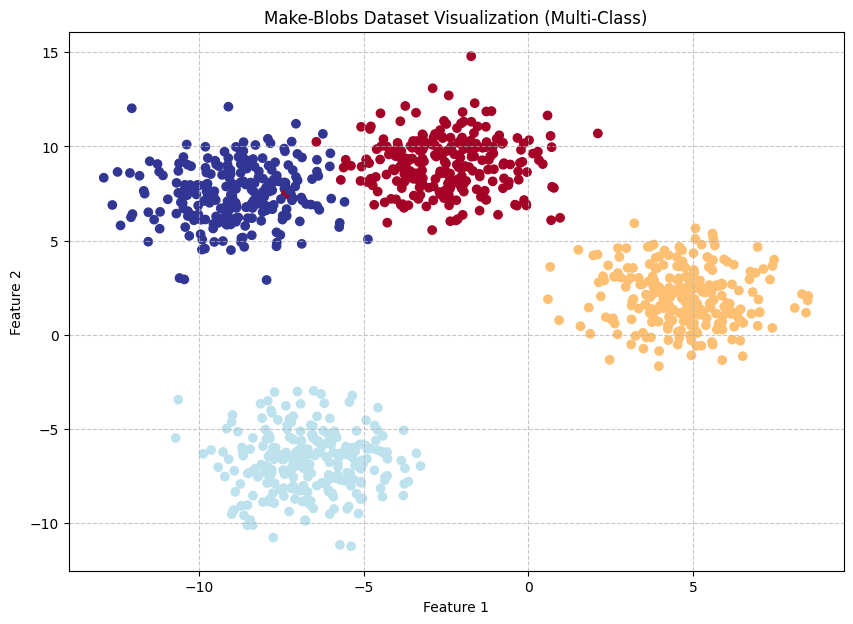

In [49]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.title("Make-Blobs Dataset Visualization (Multi-Class)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 1.3. Create Device Agnostic Code Setup
For efficient computation, especially with larger models or datasets, it's beneficial to use a GPU (CUDA) if available. This code snippet checks for CUDA availability and sets the device variable accordingly.

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 2. Model Definition
We will define a neural network model capable of handling multi-class classification. This model will use stacked linear layers, and we'll later consider the importance of non-linear activation functions.

### 2.1. Multi-Class Model Class (BlobModel)
This model is a simple feed-forward neural network with multiple linear layers. For multi-class classification, the output layer will have output_features equal to NUM_CLASSES.

In [51]:
class BlobModel(nn.Module):
    """
    A simple feed-forward neural network for multi-class classification.
    It consists of stacked linear layers. Non-linear activation functions
    are crucial for learning complex patterns, and their impact will be
    demonstrated by comparing this model (without explicit non-linearity here)
    to one that would include them.
    """
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_stack_layer = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_stack_layer(x) 

### Instantiate the Model
Create an instance of BlobModel with the defined NUM_FEATURES as input, NUM_CLASSES as output, and a specified number of hidden_units. The model is then moved to the selected device.

In [52]:
model_0 = BlobModel(
    input_features=NUM_FEATURES, 
    output_features=NUM_CLASSES, 
    hidden_units=8               
).to(device) 

print("BlobModel (Linear Architecture):")
print(model_0)

BlobModel (Linear Architecture):
BlobModel(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)


## 3. Loss Function and Optimizer
For multi-class classification, nn.CrossEntropyLoss() is the standard loss function. It combines nn.LogSoftmax and nn.NLLLoss (Negative Log Likelihood Loss) for numerical stability and expects raw logits as input. torch.optim.SGD (Stochastic Gradient Descent) will be used as the optimizer.

In [53]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1) 

## 4. Accuracy Function
A helper function to calculate the accuracy of our model's predictions. Accuracy is the percentage of correctly classified samples.

In [54]:
def accuracy_fn(y_true, y_pred):
    """
    Calculates the accuracy of predictions for multi-class classification.
    
    Args:
        y_true (torch.Tensor): True labels (ground truth).
        y_pred (torch.Tensor): Predicted labels (after argmax on probabilities).
        
    Returns:
        float: Accuracy as a percentage.
    """
    y_true = y_true.to(y_pred.device)
    
    correct = torch.eq(y_true, y_pred).sum().item() 
    
    acc = (correct / len(y_pred)) * 100
    return acc

## 5. Training and Testing Loop
This is the core of our model's learning process. We iterate over the dataset multiple times (epochs), perform forward and backward passes, update parameters, and evaluate performance on both training and test sets.

In [55]:
torch.manual_seed(RANDOM_SEED)

epochs = 1000 

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

print("--- Training BlobModel (Linear Architecture) ---")
for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_blob_train)
    
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 

    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode(): 
        test_logits = model_0(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

--- Training BlobModel (Linear Architecture) ---
Epoch: 0 | Train Loss: 1.92116, Train Acc: 26.00% | Test Loss: 0.85459, Test Acc: 55.00%
Epoch: 100 | Train Loss: 0.03655, Train Acc: 99.00% | Test Loss: 0.02813, Test Acc: 99.50%
Epoch: 200 | Train Loss: 0.03076, Train Acc: 99.00% | Test Loss: 0.02120, Test Acc: 99.50%
Epoch: 300 | Train Loss: 0.02908, Train Acc: 99.00% | Test Loss: 0.01879, Test Acc: 99.50%
Epoch: 400 | Train Loss: 0.02821, Train Acc: 99.00% | Test Loss: 0.01744, Test Acc: 99.50%
Epoch: 500 | Train Loss: 0.02761, Train Acc: 99.00% | Test Loss: 0.01652, Test Acc: 99.50%
Epoch: 600 | Train Loss: 0.02714, Train Acc: 99.00% | Test Loss: 0.01582, Test Acc: 99.50%
Epoch: 700 | Train Loss: 0.02674, Train Acc: 99.00% | Test Loss: 0.01526, Test Acc: 99.50%
Epoch: 800 | Train Loss: 0.02638, Train Acc: 99.00% | Test Loss: 0.01478, Test Acc: 99.50%
Epoch: 900 | Train Loss: 0.02605, Train Acc: 99.00% | Test Loss: 0.01436, Test Acc: 99.50%


### Final evaluation after training

In [56]:
model_0.eval()
with torch.inference_mode():

    y_logits_final = model_0(X_blob_test)
    y_pred_final = torch.softmax(y_logits_final, dim=1).argmax(dim=1)
    
    final_test_loss = loss_fn(y_logits_final, y_blob_test).item()
    final_test_acc = accuracy_fn(y_true=y_blob_test, y_pred=y_pred_final)
    
    print(f"\n--- Final Linear Model Performance ---")
    print(f"Final Test Loss: {final_test_loss:.4f}")
    print(f"Final Test Accuracy: {final_test_acc:.2f}%")


--- Final Linear Model Performance ---
Final Test Loss: 0.0140
Final Test Accuracy: 99.50%


## 5.3. Making and Evaluating Predictions
After training, we can use the model to make predictions on unseen data (e.g., the test set) and compare them to the true labels.

In [57]:
model_0.eval()

with torch.inference_mode():
    
    y_logits = model_0(X_blob_test)

print("First 10 raw logits from model_0:")
print(y_logits[:10])

y_pred_probs = torch.softmax(y_logits, dim=1)

y_preds = y_pred_probs.argmax(dim=1)

print(f"\nPredictions (first 10): {y_preds[:10]}")
print(f"True Labels (first 10): {y_blob_test[:10]}")

final_accuracy = accuracy_fn(y_true=y_blob_test, y_pred=y_preds)
print(f"Overall Test Accuracy: {final_accuracy:.1f}%")

First 10 raw logits from model_0:
tensor([[ 12.4970,  24.7421, -15.0917,  -7.1246],
        [  1.3266, -31.9169,  -2.1882,   9.4453],
        [-18.0625, -34.6041,  22.4316,   8.8713],
        [  6.5570,  17.8231,  -7.6909,  -5.4311],
        [ 15.1734,   6.6632, -18.9187,  -1.3874],
        [  0.7212, -39.3213,  -1.5895,  11.6723],
        [-17.0000, -26.6073,  21.2648,   6.4956],
        [ 11.1814,  -3.5215, -14.0736,   1.4480],
        [-20.9691, -47.8901,  25.8230,  12.7361],
        [ 12.4188,   0.2065, -15.5621,   0.3940]])

Predictions (first 10): tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
True Labels (first 10): tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Overall Test Accuracy: 99.5%


## 6. Visualization of Decision Boundaries
To visually assess how well our model has learned to separate the different classes, we'll plot its decision boundary. This shows the regions where the model predicts each class.

### 6.1. Download Helper Functions
We'll download a helper_functions.py script from a public GitHub repository. This script contains utility functions for plotting, including plot_decision_boundary.

In [58]:
import requests
from pathlib import Path 

helper_functions_path = Path("helper_functions.py")

if helper_functions_path.is_file():
  print(f"{helper_functions_path} already exists, skipping download.")
else:
  print(f"Downloading {helper_functions_path}...")
  request_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
  try:
      request = requests.get(request_url)
      request.raise_for_status() 
      with open(helper_functions_path, "wb") as f:
        f.write(request.content)
      print(f"{helper_functions_path} downloaded successfully.")
  except requests.exceptions.RequestException as e:
      print(f"Error downloading helper_functions.py: {e}")
      print("Please ensure you have an internet connection or download it manually from:")
      print(request_url)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download.


### 6.2. Plot Decision Boundaries
We will plot the decision boundary for model_0 on both the training and test sets. Since BlobModel (as defined here) is a linear model, its decision boundaries will be straight lines.

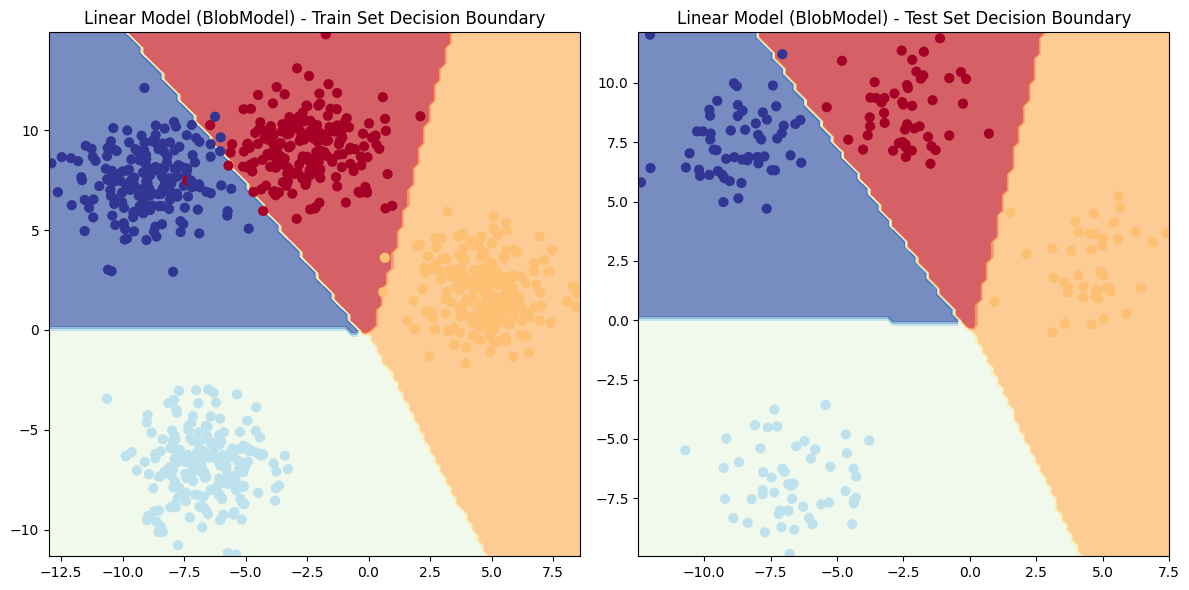

BlobModel(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [59]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
plt.title("Linear Model (BlobModel) - Train Set Decision Boundary")
plot_decision_boundary(model_0.to("cpu"), X_blob_train.to("cpu"), y_blob_train.to("cpu"))

plt.subplot(1, 2, 2) 
plt.title("Linear Model (BlobModel) - Test Set Decision Boundary")
plot_decision_boundary(model_0.to("cpu"), X_blob_test.to("cpu"), y_blob_test.to("cpu"))

plt.tight_layout() 
plt.show()

model_0.to(device)

## 7. Importance of Non-Linear Activation Functions (for Multi-Class)
The BlobModel above, without explicit non-linear activation functions, is a linear model. For a dataset like make_blobs where classes are often separable by straight lines, it can perform well. However, for more complex, non-linearly separable data (like make_circles from the previous notebook), linear models fail.

To handle non-linear data, we introduce activation functions like ReLU.

### 7.1. Model Class with Non-Linearity (BlobModel_V1)
This version of the model is similar to BlobModel but explicitly includes nn.ReLU() activations between the linear layers.

In [60]:
class BlobModel_V1(nn.Module):
    """
    A non-linear model for multi-class classification, incorporating ReLU activation functions.
    ReLU introduces non-linearity, enabling the model to learn complex decision boundaries.
    """
    def __init__(self, input_features, output_features, hidden_units=10): # Increased hidden units slightly
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

### Instantiate the Non-Linear Model

In [61]:
model_1 = BlobModel_V1(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_units=10 
).to(device)

print("BlobModel_V1 (Non-Linear Architecture):")
print(model_1)

BlobModel_V1 (Non-Linear Architecture):
BlobModel_V1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)


### 7.2. Loss Function and Optimizer for Non-Linear Model
We'll use the same CrossEntropyLoss and SGD optimizer for consistency.


In [62]:
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.1)

### 7.3. Training and Testing Loop for Non-Linear Model
We train model_1 to see how it performs with non-linearity. For make_blobs, it should also achieve high accuracy, but this architecture is more robust for general classification tasks.

In [63]:
torch.manual_seed(RANDOM_SEED)

epochs = 1000

print("\n--- Training BlobModel_V1 (Non-Linear Architecture) ---")
for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn_1(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn_1(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.4f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


--- Training BlobModel_V1 (Non-Linear Architecture) ---
Epoch: 0 | Train Loss: 1.5087, Train Acc: 2.75% | Test Loss: 1.4117, Test Acc: 1.50%
Epoch: 100 | Train Loss: 0.0381, Train Acc: 99.00% | Test Loss: 0.0293, Test Acc: 99.50%
Epoch: 200 | Train Loss: 0.0293, Train Acc: 99.00% | Test Loss: 0.0193, Test Acc: 99.50%
Epoch: 300 | Train Loss: 0.0274, Train Acc: 99.12% | Test Loss: 0.0168, Test Acc: 99.50%
Epoch: 400 | Train Loss: 0.0265, Train Acc: 99.12% | Test Loss: 0.0156, Test Acc: 99.50%
Epoch: 500 | Train Loss: 0.0259, Train Acc: 99.12% | Test Loss: 0.0148, Test Acc: 99.50%
Epoch: 600 | Train Loss: 0.0254, Train Acc: 99.25% | Test Loss: 0.0143, Test Acc: 99.50%
Epoch: 700 | Train Loss: 0.0250, Train Acc: 99.25% | Test Loss: 0.0138, Test Acc: 99.50%
Epoch: 800 | Train Loss: 0.0246, Train Acc: 99.25% | Test Loss: 0.0134, Test Acc: 99.50%
Epoch: 900 | Train Loss: 0.0243, Train Acc: 99.25% | Test Loss: 0.0131, Test Acc: 99.50%


### Final evaluation after training

In [64]:
model_1.eval()
with torch.inference_mode():
    y_logits_final_v1 = model_1(X_blob_test)
    y_pred_final_v1 = torch.softmax(y_logits_final_v1, dim=1).argmax(dim=1)
    
    final_test_loss_v1 = loss_fn_1(y_logits_final_v1, y_blob_test).item()
    final_test_acc_v1 = accuracy_fn(y_true=y_blob_test, y_pred=y_pred_final_v1)
    
    print(f"\n--- Final Non-Linear Model Performance ---")
    print(f"Final Test Loss: {final_test_loss_v1:.4f}")
    print(f"Final Test Accuracy: {final_test_acc_v1:.2f}%")


--- Final Non-Linear Model Performance ---
Final Test Loss: 0.0128
Final Test Accuracy: 99.50%


7.4. Plot Decision Boundaries for Non-Linear Model

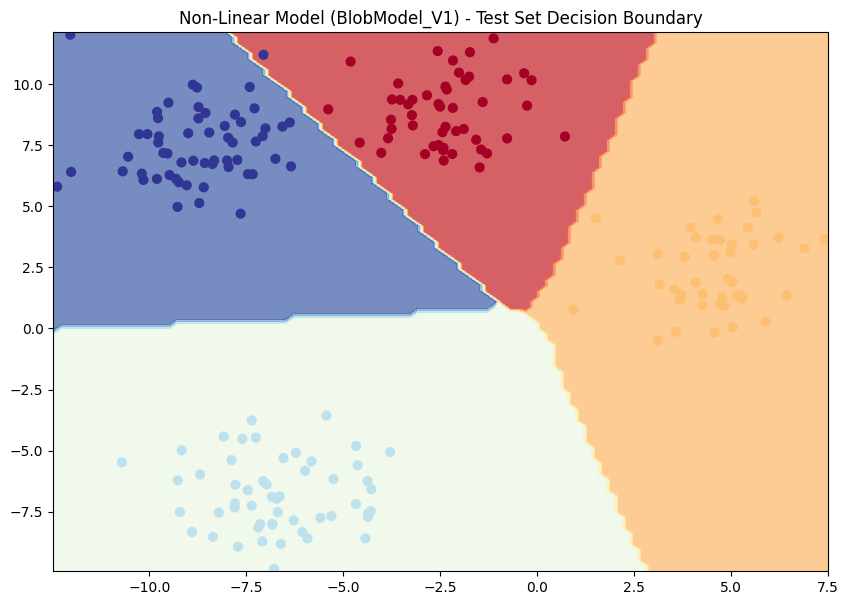

BlobModel_V1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [65]:
plt.figure(figsize=(10, 7))
plt.title("Non-Linear Model (BlobModel_V1) - Test Set Decision Boundary")
plot_decision_boundary(model_1.to("cpu"), X_blob_test.to("cpu"), y_blob_test.to("cpu"))
plt.show()

model_1.to(device)

8. Conclusion
This notebook demonstrates the process of multi-class classification using PyTorch. We've covered:
- Generating a synthetic multi-class dataset (make_blobs).
- Preparing data by converting to tensors and splitting into train/test sets.
- Setting up device-agnostic code.
- Defining a neural network model (BlobModel).
- Choosing appropriate loss functions (nn.CrossEntropyLoss) and optimizers (torch.optim.SGD).
- Building a training and testing loop.
- Evaluating model performance using loss and accuracy.
- Visualizing decision boundaries to understand how the model separates classes.

The make_blobs dataset is relatively easy for even linear models to separate if cluster_std is small. However, the BlobModel_V1 with ReLU activations provides a more general and powerful architecture suitable for complex, non-linear classification problems.